In [1]:
import os, subprocess, json
from typing import List, Tuple, Dict
from dataclasses import dataclass

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme()

In [2]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
seq_db = os.path.join(base_dir, "input", "sequence_db")

#Path to the benchmark databases
db_len_path = os.path.join(base_dir, "input", "sequence_db", "BM_db_e6")
db_nb_path = os.path.join(base_dir, "input", "sequence_db", "BM_db_100")

out_analysis_path = os.path.join(base_dir, "output", "analysis")

#Path to the modules
db_code = os.path.join(base_dir, "code")

# Benchmark of the detection of HGT by the different metrics

In [3]:
def prepare_HGT_db(input_db : str, output_db : str, iterations : int = 1000, proba : float = 0.05):
    """
    Prepare the artificial database of HGTs
    """
    os.chdir(db_code)
    subprocess.run(
        f"python -m HGTransfer -db {input_db} -o {output_db} -i {iterations} -p {proba}"
        )
    return output_db

def compute_signatures(input_db : str, metric_num : int, metric_name : str):
    """
    Compute the signatures for the database where HGT occured
    """
    os.chdir(db_code)

    subprocess.run(
        f"python -m compute_signatures {input_db} -m {metric_num}"
        )
    return f"{input_db}_{metric_name}.json"

def backtrack_analysis(output_db : str, json_file : str, eval_file : str):
    """
    Compute the backtrack analysis for detected HGTs into the database.
    """
    os.chdir(db_code)

    subprocess.run(
        f"python -m analysis {json_file} {output_db} -r {eval_file}"
    )
    return 0

In [4]:
def load_summaries(output_db, ref_file : str, json_file : str):
    """
    Load files for evaluation.
    """
    json_path = os.path.join(base_dir, "output", "transfer_summary", json_file)
    with open(json_path, 'r', encoding='utf-8') as jfile :
        json_raw = json.load(jfile)

    ref_path = os.path.join(seq_db, output_db, ref_file)

    with open(ref_path, 'r') as ref_raw :
        ref_raw = ref_raw.readlines()
    
    ref_dico = {}
    for ref in ref_raw[1:]:
        sending, sd_start, sd_end, receiving, rc_pos = ref.split('\t\t')
        ref_dico[receiving] = int(rc_pos.strip())
    return json_raw, ref_dico


def eval(json_raw : Dict[str, Dict[int, float]], ref_dico : Dict[str, int], window : int = 5000):
    """
    Check how many generated HGT are caught.
    """
    count = 0
    for receiver, position in ref_dico.items():
        if json_raw[receiver]:
            pass
        else:
            continue

        if any((position > int(loc)-window and position < int(loc)+2*window) for loc, intensity in json_raw[receiver].items()):
            count += 1
    
    return count

def get_backtrack_results(eval_report_path : str, path_db_report : str):
    with open(eval_report_path, 'r') as eval_report:
        report = len(eval_report.readlines())
    
    with open(path_db_report, 'r') as generator_report:
        generator_size = len(generator_report.readlines())
    return report, generator_size

        
def benchmark_HGT_detection(input_db : str, output_db : str):
    couples_metric = { 
        "L2_distance" : 0,
        "Chi-squared_distance" : 1,
        "KL_divergence" : 2,
        "average_frequency" : 3
    }
    results_metric = {metric : {"accuracy_score" : 0, "TP_ratio" : 0} for metric in couples_metric.keys()}
    stats_metric = {metric : {"TP" : 0, "FN":0} for metric in couples_metric.keys()}

    output_db = prepare_HGT_db(input_db, output_db, proba=0.25)
    gen_db_report = os.path.join(seq_db, output_db, "HGT_report.txt")

    for metric_name, num_metric in couples_metric.items():
        json_summary = compute_signatures(output_db, metric_name=metric_name, metric_num=num_metric)
        json_raw, ref_dico = load_summaries(output_db, "HGT_report.txt", json_summary)
        
        avg_finding = sum([len(summary) for summary in json_raw.values()])/len(json_summary)

        found_HGT = eval(json_raw, ref_dico)
        results_metric[metric_name]["accuracy_score"] = found_HGT/len(ref_dico) # accuracy respect to artificial HGT
        results_metric[metric_name]["TP_ratio"] = found_HGT/avg_finding

        backtrack_analysis(output_db, json_summary, gen_db_report)

        eval_report_path = os.path.join(out_analysis_path, "eval_analysis_report.txt")
        tp, tot_HGT = get_backtrack_results(eval_report_path, gen_db_report)
        fn = tot_HGT-tp

        stats_metric[metric_name]["TP"] = tp
        stats_metric[metric_name]["FN"] = fn 

    
    return pd.DataFrame(data=results_metric), pd.DataFrame(data=stats_metric)
    
result_df, stats_df = benchmark_HGT_detection("Brinkman", "generator_db")

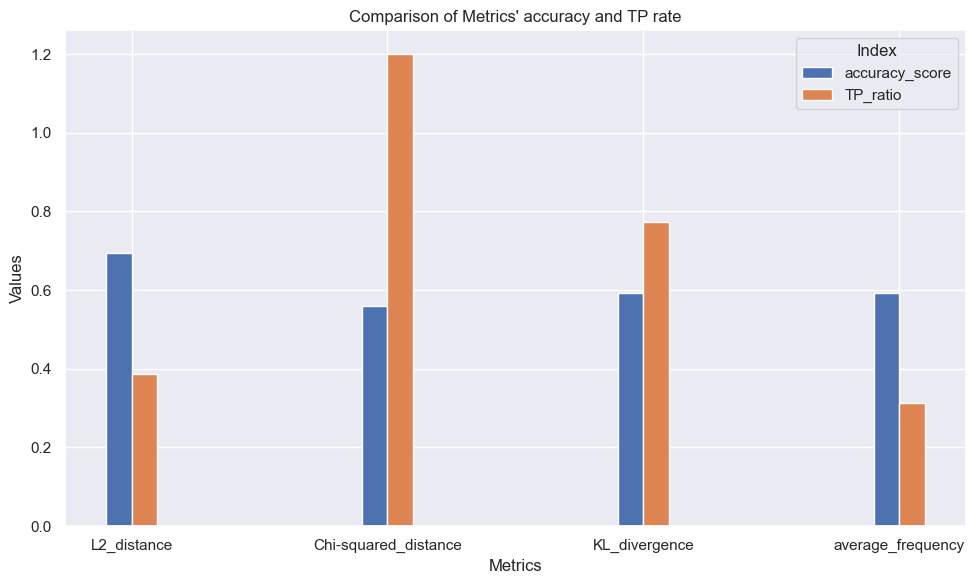

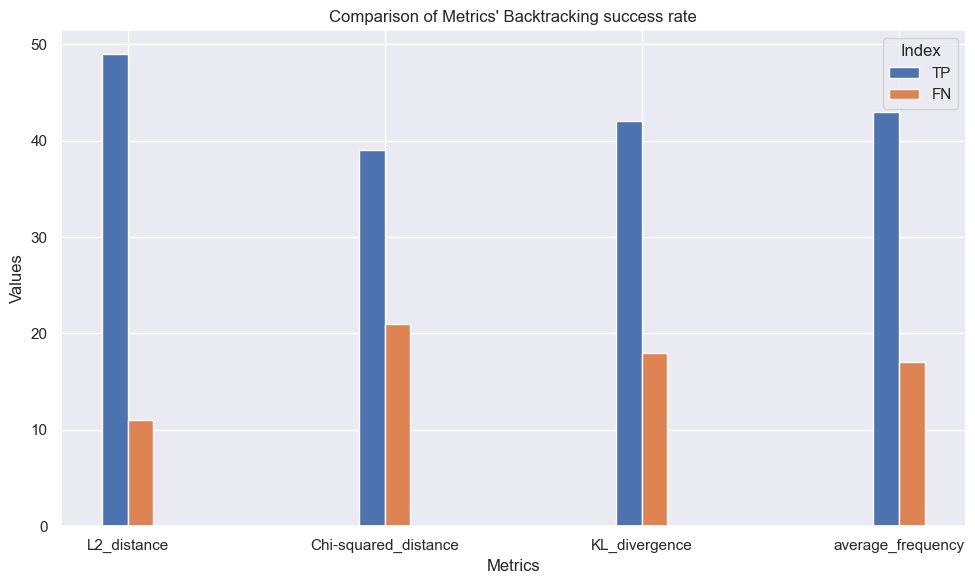

In [5]:
def show_results(result_df: pd.DataFrame, job : str):
    bar_width = 0.1  
    indices = np.arange(len(result_df.columns))  
    index_labels = result_df.index  

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, index in enumerate(index_labels):
        ax.bar(indices + i * bar_width, result_df.loc[index], bar_width, label=index)

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title(f"Comparison of Metrics' {job}")
    ax.set_xticks(indices + bar_width * (len(index_labels) - 1) / 2)
    ax.set_xticklabels(result_df.columns)
    ax.legend(title="Index")

    plt.tight_layout()
    plt.show()


show_results(result_df, "accuracy and TP rate")
show_results(stats_df, "Backtracking success rate")

In [6]:
stats_df

,L2_distance,Chi-squared_distance,KL_divergence,average_frequency
TP,49,39,42,43
FN,11,21,18,17


In [7]:
result_df

,L2_distance,Chi-squared_distance,KL_divergence,average_frequency
accuracy_score,0.694915,0.559322,0.593220,0.59322
TP_ratio,0.385538,1.200000,0.773894,0.31346
